In [2]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [ ]:
import importlib
import modules.beta_trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_hopper

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.beta_trainer)
importlib.reload(env.custom_hopper)

# Re-import the specific functions into the global namespace
from modules.beta_trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

print("Modules reloaded successfully!")

In [3]:
from modules.beta_trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

Starting evaluation of 4 models...
Loading: ../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/doraemon_masses_friction_damping_final_model.zip...
Loading: ../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/udr_baseline_1.1x.zip...
Loading: ../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/udr_baseline_2x.zip...
Loading: ../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/udr_baseline_10x.zip...


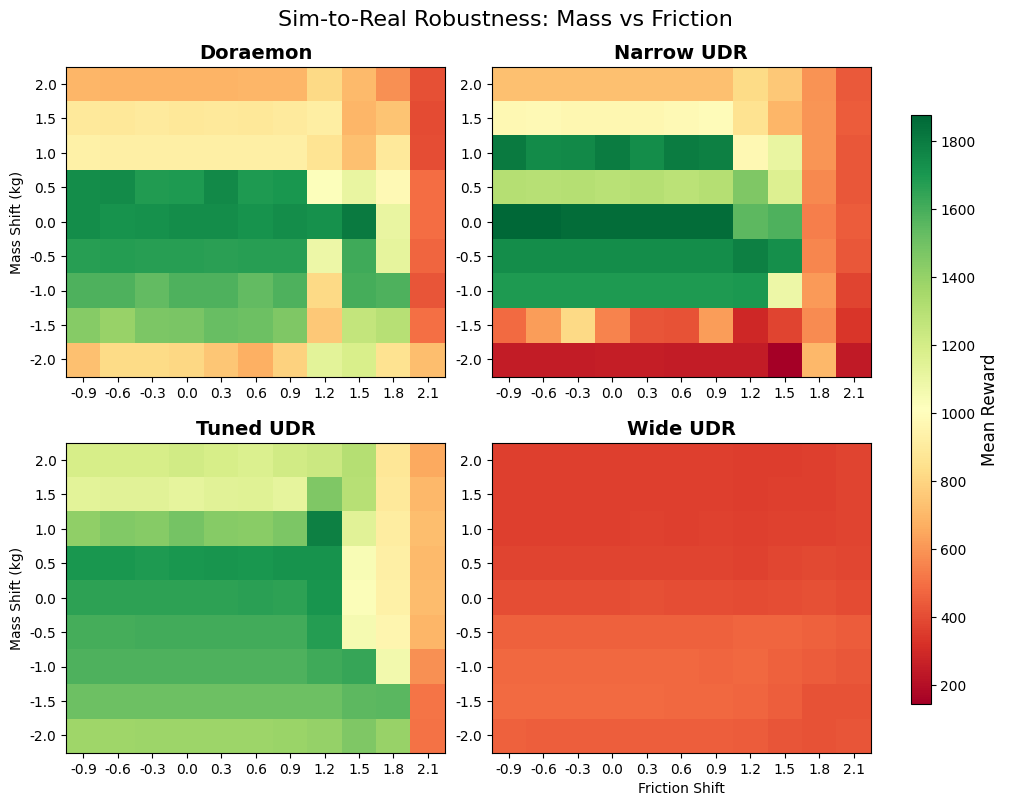

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy

# --- 1. CONFIGURATION ---

# Path to your models
models_dir = "../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/"

# List of models and their corresponding VecNormalize files
# Format: (Title for Plot, Model Filename, VecNormalize Filename)
models_config = [
    # ("Doraemon Masses", 
    #  "doraemon_masses_final_model.zip", 
    #  "doraemon_masses_final_vecnormalize.pkl"),
     
    ("Doraemon", 
     "doraemon_masses_friction_damping_final_model.zip", 
     "doraemon_masses_friction_damping_final_vecnormalize.pkl"),
     
    ("Narrow UDR", 
     "udr_baseline_1.1x.zip", 
     "udr_baseline_1.1x_vecnormalize.pkl"),
     
    ("Tuned UDR", 
     "udr_baseline_2x.zip", 
     "udr_baseline_2x_vecnormalize.pkl"),
     
    ("Wide UDR", 
     "udr_baseline_10x.zip", 
     "udr_baseline_10x_vecnormalize.pkl"),
]

# Define the grid ranges for evaluation
# Adjust these lists to change the resolution of your heatmap
mass_shifts = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
friction_shifts = [-0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]

n_eval_episodes = 20  # Keeping this low for speed. Increase to 20+ for final paper results.

# --- 2. EVALUATION FUNCTIONS ---

def get_performance_grid(model_path, norm_path, m_shifts, f_shifts):
    """
    Evaluates a single model across the 2D grid of mass and friction shifts.
    Returns a 2D matrix of mean rewards.
    """
    print(f"Loading: {model_path}...")
    model = SAC.load(model_path, device="cpu")
    
    # Initialize grid: Rows (Mass) x Cols (Friction)
    reward_matrix = np.zeros((len(m_shifts), len(f_shifts)))
    
    for i, m_shift in enumerate(m_shifts):
        for j, f_shift in enumerate(f_shifts):
            
            # Create environment with specific shift
            try:
                env = gym.make("CustomHopper-shift-v0", mass_shift=m_shift, floor_friction_shift=f_shift)
            except gym.error.NameNotFound:
                print("Error: 'CustomHopper-shift-v0' not found. Make sure your custom env is registered.")
                return None

            env = DummyVecEnv([lambda: env])
            
            # Load normalization stats if they exist
            if os.path.exists(norm_path):
                try:
                    env = VecNormalize.load(norm_path, env)
                    env.training = False
                    env.norm_reward = False
                except Exception as e:
                    print(f"Warning loading VecNormalize: {e}")
            
            # Evaluate
            episode_rewards, _ = evaluate_policy(
                model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True
            )
            
            mean_reward = np.mean(episode_rewards)
            reward_matrix[i, j] = mean_reward
            
            env.close()
            
    return reward_matrix

# --- 3. MAIN LOOP ---

all_matrices = []
titles = []

print(f"Starting evaluation of {len(models_config)} models...")

for config in models_config:
    title, model_file, norm_file = config
    full_model_path = os.path.join(models_dir, model_file)
    full_norm_path = os.path.join(models_dir, norm_file)
    
    matrix = get_performance_grid(full_model_path, full_norm_path, mass_shifts, friction_shifts)
    all_matrices.append(matrix)
    titles.append(title)

# --- 4. PLOTTING ---

# Determine global min and max for consistent coloring across all plots
global_min = min([np.min(m) for m in all_matrices])
global_max = max([np.max(m) for m in all_matrices])

# Setup Figure: 3 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()  # Flatten to easy 1D indexing

# Color map: 'RdYlGn' goes from Red (low) to Green (high)
cmap = 'RdYlGn'

for i, ax in enumerate(axes):
    if i < len(all_matrices):
        matrix = all_matrices[i]
        
        # Create Heatmap
        # We assume origin='lower' so the Y-axis increases upwards
        im = ax.imshow(matrix, cmap=cmap, vmin=global_min, vmax=global_max, origin='lower')
        
        # Configure Ticks
        ax.set_title(titles[i], fontsize=14, fontweight='bold')
        
        # X-Axis (Friction)
        ax.set_xticks(np.arange(len(friction_shifts)))
        ax.set_xticklabels(friction_shifts)
        if i >= 3: # Only show X label for bottom plots
            ax.set_xlabel("Friction Shift", fontsize=10)
        
        # Y-Axis (Mass)
        ax.set_yticks(np.arange(len(mass_shifts)))
        ax.set_yticklabels(mass_shifts)
        if i % 2 == 0: # Only show Y label for left plots
            ax.set_ylabel("Mass Shift (kg)", fontsize=10)

        # # Annotate values inside the squares (optional, good for readability)
        # for y in range(len(mass_shifts)):
        #     for x in range(len(friction_shifts)):
        #         text_color = "black" if (matrix[y, x] > (global_max+global_min)/2) else "white"
        #         ax.text(x, y, f"{matrix[y, x]:.0f}", ha="center", va="center", color="black", fontsize=8)

    else:
        # Hide the empty 6th subplot
        ax.axis('off')

# --- 5. SHARED COLORBAR ---
# We use the list of axes so the colorbar spans all of them correctly
im = axes[0].images[0] # Get the image data from the first plot for the colorbar
cbar = fig.colorbar(im, ax=axes, location='right', aspect=30, shrink=0.8)
cbar.set_label('Mean Reward', fontsize=12)

plt.suptitle("Sim-to-Real Robustness: Mass vs Friction", fontsize=16)

plt.show()

In [ ]:
import os
import time
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# --- CONFIGURATION ---
MODELS_DIR = "../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/"
model_filename = "doraemon_masses_friction_damping_final_model.zip"
norm_filename = "doraemon_masses_friction_damping_final_vecnormalize.pkl"

mass_shift = 0
friction_shift = 1.5

# --- 1. SETUP ENVIRONMENT ---
env = DummyVecEnv([lambda: gym.make(
    "CustomHopper-shift-v0", 
    render_mode="human", 
    mass_shift=mass_shift, 
    floor_friction_shift=friction_shift
)])

# --- 2. LOAD NORMALIZATION ---
norm_path = os.path.join(MODELS_DIR, norm_filename)
if os.path.exists(norm_path):
    print(f"Loading normalization stats from: {norm_path}")
    env = VecNormalize.load(norm_path, env)
    env.training = False
    env.norm_reward = False
else:
    print("WARNING: VecNormalize file not found!")

# --- 3. LOAD MODEL ---
model_path = os.path.join(MODELS_DIR, model_filename)
model = SAC.load(model_path, device="cpu")

# --- 4. RENDER LOOP WITH CAMERA TRACKING ---
print(f"Rendering with Camera Tracking... (Press Ctrl+C to stop)")
obs = env.reset()

# Get a reference to the inner unwrapped environment to access the viewer/data
# We need to dig through DummyVecEnv -> Monitor/TimeLimit -> CustomHopper
inner_env = env.envs[0].unwrapped 

try:
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = env.step(action)
        
        # Render first to ensure the viewer window exists
        env.render()
        
        # --- CAMERA TRACKING LOGIC ---
        # Check if the viewer is active
        if hasattr(inner_env, 'mujoco_renderer') and inner_env.mujoco_renderer.viewer:
            viewer = inner_env.mujoco_renderer.viewer
            
            # Hopper moves primarily along the X-axis (qpos[0])
            # We update the camera's 'lookat' point to match the robot's X position
            x_pos = inner_env.data.qpos[0]
            viewer.cam.lookat[0] = x_pos
            
            # Optional: Adjust camera distance/elevation if needed
            # viewer.cam.distance = 5.0 
            # viewer.cam.elevation = -20
        # -----------------------------

        time.sleep(1.0 / 60.0)
        
        if dones[0]:
            obs = env.reset()
            # On reset, the camera might snap back. 
            # The loop will catch it and re-center it on the next frame.

except KeyboardInterrupt:
    print("\nRendering stopped.")
    env.close()

Loading normalization stats from: ../results/hopper/sac_doraemon_randomized_masses_friction_damping/models/doraemon_masses_friction_damping_final_vecnormalize.pkl
Rendering with Camera Tracking... (Press Ctrl+C to stop)

Rendering stopped.
